In [43]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from utils import tile_raster_images
import pdb
import os
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [44]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [45]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.to_float(tf.random_uniform(tf.shape(probs)) <= probs)

def draw_weights(W, shape, N, stat_shape, interpolation="bilinear"):
    """Vizualizacija težina
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    image = (tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/stat_shape[0])), stat_shape[0]),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    plt.axis('off')
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, N):
    """Vizualizacija ulaza i pripadajućih rekonstrukcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    N -- broj uzoraka
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):
        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(states[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
        plt.axis('off')
    plt.tight_layout()

def draw_generated(stin, stout, gen, shape_gen, shape_state, N):
    """Vizualizacija zadanih skrivenih stanja, konačnih skrivenih stanja i pripadajućih rekonstrukcija
    stin -- početni skriveni sloj 
    stout -- rekonstruirani vektori
    gen -- vektori stanja skrivenog sloja
    shape_gen -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    N -- broj uzoraka
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):

        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(stin[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("set state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(stout[i][0:784].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("final state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(gen[i].reshape(shape_gen), vmin=0, vmax=1, interpolation="nearest")
        plt.title("generated visible")
        plt.axis('off')
    plt.tight_layout()
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    """ Iscrtavanje jedne iteracije u kreiranju vidljivog sloja
    inp - vidljivi sloj
    title - naslov sličice
    size - 2D dimenzije vidljiovg sloja
    Nrows - maks. broj redaka sličica
    in-a-row . broj sličica u jednom redu
    j - pozicija sličice u gridu
    """
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases, h_count):
    """ Slijedno iscrtavanje rekonstrukcije vidljivog sloja
    ind - indeks znamenke u orig (matrici sa znamenkama kao recima)
    states - vektori stanja ulaznih vektora
    orig - originalnalni ulazni vektori
    weights - matrica težina
    biases - vektori pomaka vidljivog sloja
    """
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(h_count):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()

## Zadatak 1

In [16]:
class RBM:
    def __init__(self, v_count, v_shape, h1_count, h1_shape, gibbs_sampling_steps, learning_rate):
        self.v_count = v_count; self.v_shape = v_shape
        self.h1_count = h1_count; self.h1_shape = h1_shape

        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X1 = tf.placeholder("float", [None, v_count])
            self.w1 = weights([v_count, h1_count])
            self.vb1 = bias([v_count])
            self.hb1 = bias([h1_count])

            # add here
            self.h0_prob = tf.nn.sigmoid(tf.matmul(self.X1, self.w1) + self.hb1)
            self.h0 = sample_prob(self.h0_prob)
            self.h1 = self.h0

            for step in range(gibbs_sampling_steps):
                # add here
                self.v1_prob = tf.nn.sigmoid(tf.matmul(self.h1, self.w1, transpose_b=True) + self.vb1)
                self.v1 = sample_prob(self.v1_prob)
                h1_prob = tf.nn.sigmoid(tf.matmul(self.v1, self.w1) + self.hb1)
                self.h1 = sample_prob(h1_prob)

            # add here
            w1_positive_grad = tf.matmul(self.X1, self.h0, transpose_a=True)
            w1_negative_grad = tf.matmul(self.v1, self.h1, transpose_a=True)

            dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(self.X1)[0])

            update_w1 = tf.assign_add(self.w1, learning_rate * dw1)
            update_vb1 = tf.assign_add(self.vb1, learning_rate * tf.reduce_mean(self.X1 - self.v1, 0))
            update_hb1 = tf.assign_add(self.hb1, learning_rate * tf.reduce_mean(self.h0 - self.h1, 0)) 

            self.out1 = (update_w1, update_vb1, update_hb1)

            # add here
            self.v1_prob = tf.nn.sigmoid(tf.matmul(self.h1, self.w1, transpose_b=True) + self.vb1)
            self.v1 = sample_prob(self.v1_prob)

            err1 = self.X1 - self.v1_prob
            self.err_sum1 = tf.reduce_mean(err1 * err1)
            self.initializer = tf.global_variables_initializer()   
        
    def train(self, dataset, batch_size, epochs, print_step):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        self.session = tf.Session(graph=self.graph)
        self.session.run(self.initializer)

        for i in range(total_batch):
            batch, label = dataset.next_batch(batch_size)
            err, _ = self.session.run([self.err_sum1, self.out1], feed_dict={self.X1: batch})

            if i % print_step == 0:
                print("Batch:", i, "/", total_batch, "Error:", err)
                
    def get_params(self):
        w1 = self.session.run(self.w1)
        vb1 = self.session.run(self.vb1)
        hb1 = self.session.run(self.hb1)
        return w1, vb1, hb1
    
    def get_vr(self, samples):
        vr = self.session.run(self.v1_prob, feed_dict={self.X1: teX[0:samples,:]})
        return vr

In [17]:
v_count = 784; v_shape = (28, 28)
h1_count = 100; h1_shape = (10, 10)
gibbs_sampling_steps = 1; learning_rate = 0.1
batch_size = 100; epochs = 100

rbm = RBM(v_count, v_shape, h1_count, h1_shape, gibbs_sampling_steps, learning_rate)
rbm.train(mnist.train, batch_size, epochs, 100)

Batch: 0 / 55000 Error: 0.258334
Batch: 100 / 55000 Error: 0.044294
Batch: 200 / 55000 Error: 0.0392598
Batch: 300 / 55000 Error: 0.0374345
Batch: 400 / 55000 Error: 0.0372391
Batch: 500 / 55000 Error: 0.0344688
Batch: 600 / 55000 Error: 0.0328262
Batch: 700 / 55000 Error: 0.0338487
Batch: 800 / 55000 Error: 0.0353752
Batch: 900 / 55000 Error: 0.0301046
Batch: 1000 / 55000 Error: 0.0309243
Batch: 1100 / 55000 Error: 0.0298718
Batch: 1200 / 55000 Error: 0.0312721
Batch: 1300 / 55000 Error: 0.0277585
Batch: 1400 / 55000 Error: 0.0292296
Batch: 1500 / 55000 Error: 0.0285798
Batch: 1600 / 55000 Error: 0.0292024
Batch: 1700 / 55000 Error: 0.0290995
Batch: 1800 / 55000 Error: 0.0267201
Batch: 1900 / 55000 Error: 0.0282775
Batch: 2000 / 55000 Error: 0.0263287
Batch: 2100 / 55000 Error: 0.0269804
Batch: 2200 / 55000 Error: 0.0277892
Batch: 2300 / 55000 Error: 0.0278913
Batch: 2400 / 55000 Error: 0.02689
Batch: 2500 / 55000 Error: 0.0272037
Batch: 2600 / 55000 Error: 0.0286717
Batch: 2700 / 550

Batch: 22000 / 55000 Error: 0.0197551
Batch: 22100 / 55000 Error: 0.019963
Batch: 22200 / 55000 Error: 0.0187402
Batch: 22300 / 55000 Error: 0.0192568
Batch: 22400 / 55000 Error: 0.0196644
Batch: 22500 / 55000 Error: 0.0197088
Batch: 22600 / 55000 Error: 0.020442
Batch: 22700 / 55000 Error: 0.0197036
Batch: 22800 / 55000 Error: 0.0196671
Batch: 22900 / 55000 Error: 0.0190066
Batch: 23000 / 55000 Error: 0.0203062
Batch: 23100 / 55000 Error: 0.0206424
Batch: 23200 / 55000 Error: 0.0206295
Batch: 23300 / 55000 Error: 0.0194375
Batch: 23400 / 55000 Error: 0.0192659
Batch: 23500 / 55000 Error: 0.0197061
Batch: 23600 / 55000 Error: 0.0190286
Batch: 23700 / 55000 Error: 0.0196373
Batch: 23800 / 55000 Error: 0.0193616
Batch: 23900 / 55000 Error: 0.0183284
Batch: 24000 / 55000 Error: 0.0187487
Batch: 24100 / 55000 Error: 0.0199869
Batch: 24200 / 55000 Error: 0.0186325
Batch: 24300 / 55000 Error: 0.0200731
Batch: 24400 / 55000 Error: 0.0206315
Batch: 24500 / 55000 Error: 0.0196539
Batch: 24600 /

Batch: 43700 / 55000 Error: 0.018745
Batch: 43800 / 55000 Error: 0.019771
Batch: 43900 / 55000 Error: 0.019229
Batch: 44000 / 55000 Error: 0.0188113
Batch: 44100 / 55000 Error: 0.0178274
Batch: 44200 / 55000 Error: 0.0177551
Batch: 44300 / 55000 Error: 0.0187119
Batch: 44400 / 55000 Error: 0.0180799
Batch: 44500 / 55000 Error: 0.0185913
Batch: 44600 / 55000 Error: 0.0194247
Batch: 44700 / 55000 Error: 0.0180926
Batch: 44800 / 55000 Error: 0.0201467
Batch: 44900 / 55000 Error: 0.0174882
Batch: 45000 / 55000 Error: 0.019639
Batch: 45100 / 55000 Error: 0.0185499
Batch: 45200 / 55000 Error: 0.0196411
Batch: 45300 / 55000 Error: 0.0194677
Batch: 45400 / 55000 Error: 0.0196871
Batch: 45500 / 55000 Error: 0.0195809
Batch: 45600 / 55000 Error: 0.0195825
Batch: 45700 / 55000 Error: 0.0187882
Batch: 45800 / 55000 Error: 0.018107
Batch: 45900 / 55000 Error: 0.0181704
Batch: 46000 / 55000 Error: 0.0180195
Batch: 46100 / 55000 Error: 0.0185737
Batch: 46200 / 55000 Error: 0.0195589
Batch: 46300 / 55

In [18]:
model = rbm; samples = 5000; numbers_count = 20
w1s = model.w1.eval(session=model.session)
vb1s = model.vb1.eval(session=model.session)
hb1s = model.hb1.eval(session=model.session)
vr, h1s = model.session.run([model.v1_prob, model.h1], feed_dict={model.X1: teX[0:samples,:]})

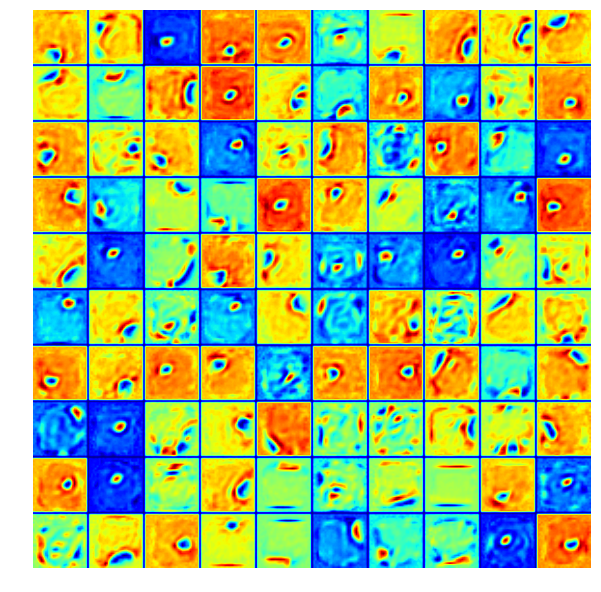

In [19]:
# vizualizacija težina
draw_weights(w1s, model.v_shape, model.h1_count, model.h1_shape)

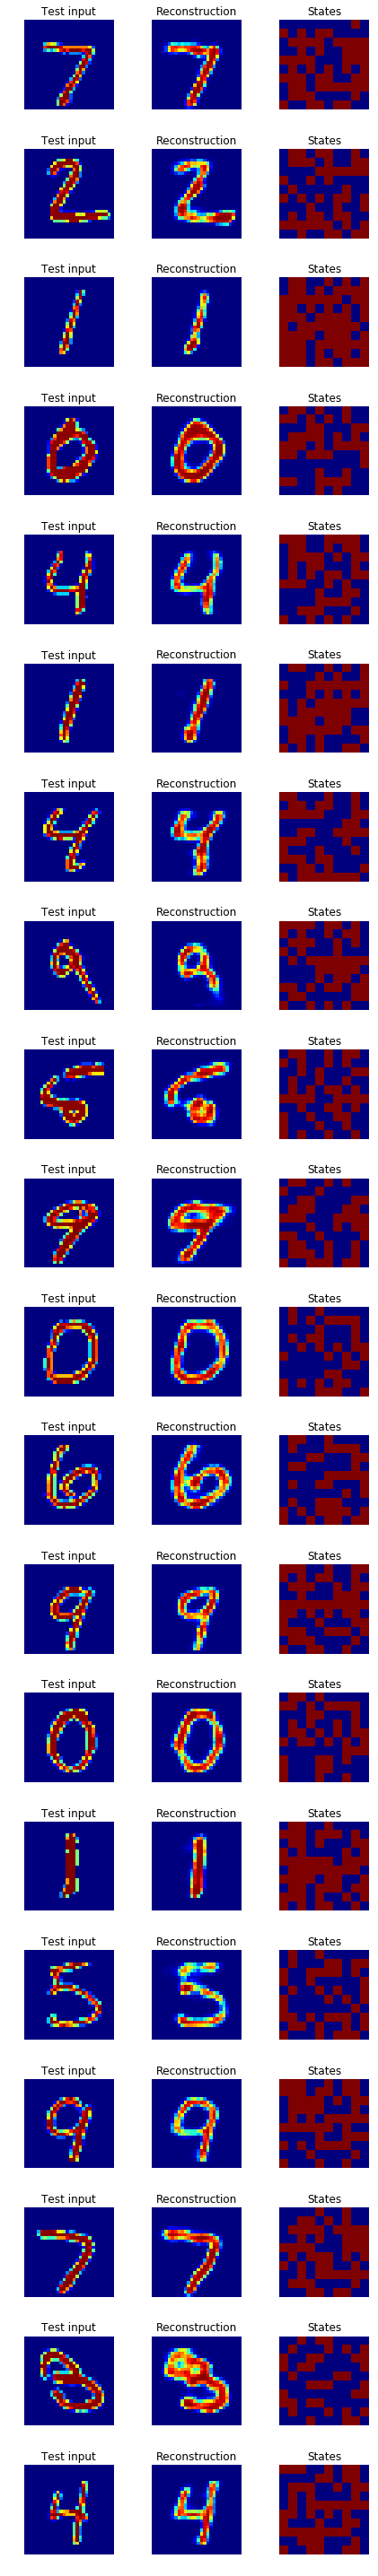

In [20]:
# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr, h1s, model.v_shape, model.h1_shape, numbers_count)

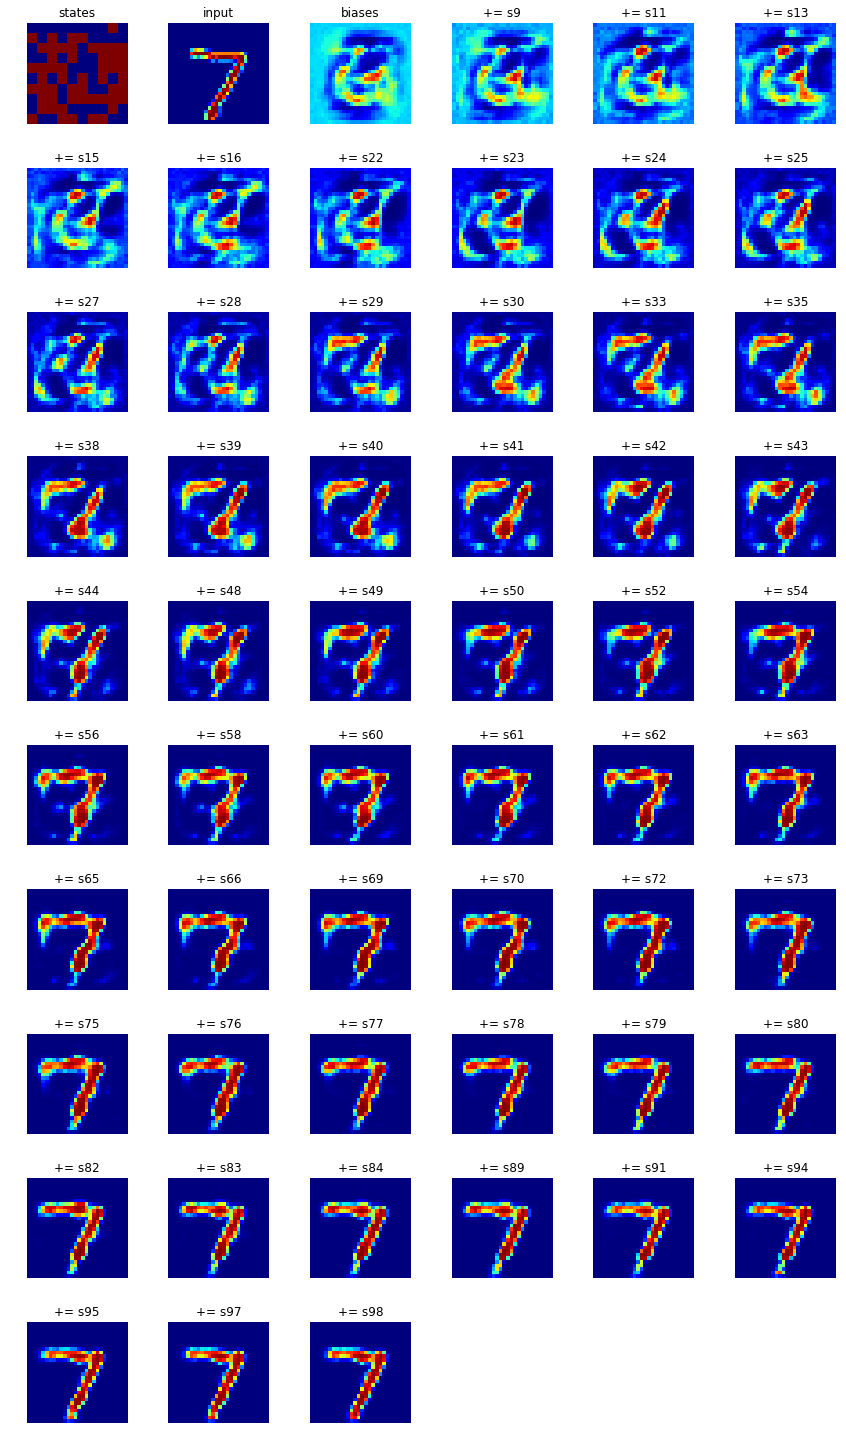

In [21]:
reconstruct(0, h1s, teX, w1s, vb1s, model.h1_count) # prvi argument je indeks znamenke u matrici znamenki

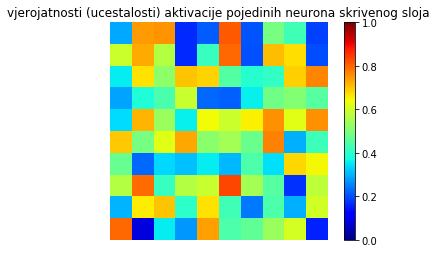

In [22]:
# Vjerojatnost da je skriveno stanje uključeno kroz Nu ulaznih uzoraka
plt.figure()
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(model.h1_shape)
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('vjerojatnosti (ucestalosti) aktivacije pojedinih neurona skrivenog sloja')
print()

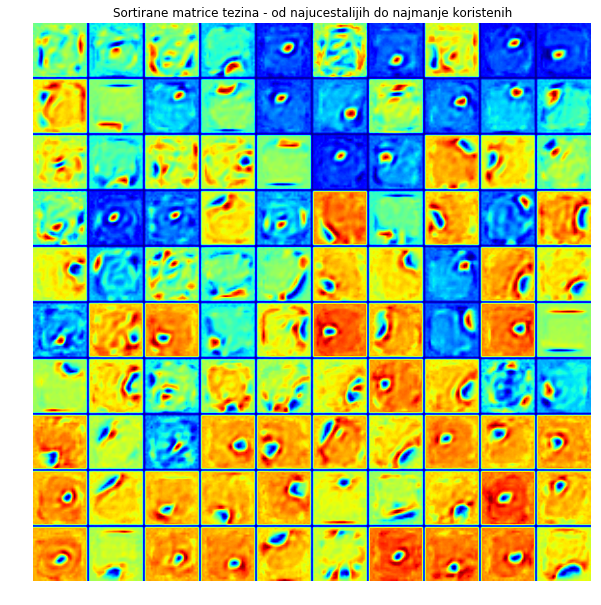

In [23]:
# Vizualizacija težina sortitranih prema učestalosti
tmp_ind = (-tmp).argsort(None)
draw_weights(w1s[:, tmp_ind], model.v_shape, model.h1_count, model.h1_shape)
plt.title('Sortirane matrice tezina - od najucestalijih do najmanje koristenih')
print()

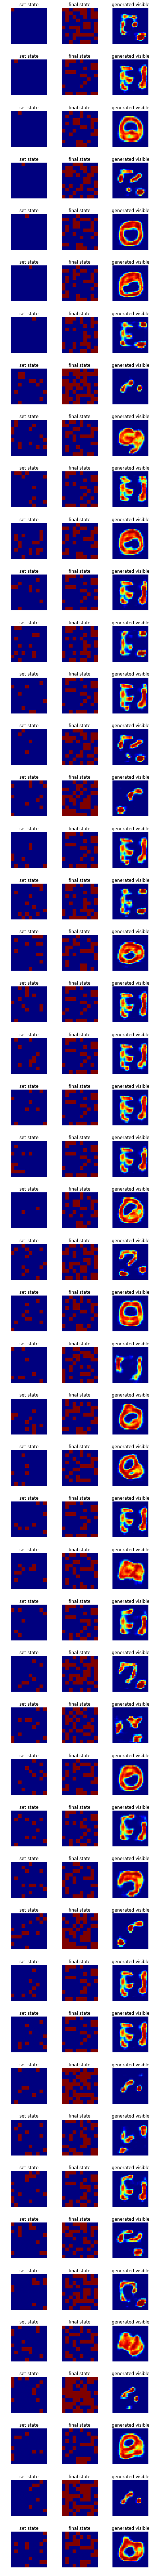

In [24]:
# Generiranje uzoraka iz slučajnih vektora
r_input = np.random.rand(100, model.h1_count)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_1 = model.session.run((model.v1), feed_dict={model.h0: r_input})

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = model.session.run((model.v1_prob, model.v1, model.h1), feed_dict={model.X1: out_1})

draw_generated(r_input, hout1, out_1_prob, model.v_shape, model.h1_shape, 50)

## Zadatak 2

In [25]:
class DBN:
    def __init__(self, v_count, v_shape, h1_count, h1_shape, h2_count, h2_shape, 
                 gibbs_sampling_steps, learning_rate, 
                 w1, vb1, hb1):
        self.v_count = v_count; self.v_shape = v_shape
        self.h1_count = h1_count; self.h1_shape = h1_shape
        self.h2_count = h2_count; self.h2_shape = h2_shape

        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X2 = tf.placeholder("float", [None, v_count])
            self.w1 = tf.Variable(w1)
            self.vb1 = tf.Variable(vb1)
            self.hb1 = tf.Variable(hb1)
            
            self.w2 = weights([h1_count, h2_count])
            self.hb2 = bias([h2_count])
            
            # Visible - First RBM
            self.h1up_prob = tf.nn.sigmoid(tf.matmul(self.X2, self.w1) + self.hb1)
            self.h1up = sample_prob(self.h1up_prob)

            # Hidden - Second RBM
            self.h2up_prob = tf.nn.sigmoid(tf.matmul(self.h1up, self.w2) + self.hb2) 
            self.h2up = sample_prob(self.h2up_prob)
            self.h2down = self.h2up
            
            for step in range(gibbs_sampling_steps):
                # add here
                self.h1down_prob = tf.nn.sigmoid(tf.matmul(self.h2down, self.w2, transpose_b=True) + self.hb1)
                self.h1down = sample_prob(self.h1down_prob)
                h2down_prob = tf.nn.sigmoid(tf.matmul(self.h1down, self.w2) + self.hb2)
                self.h2down = sample_prob(h2down_prob)

            # add here
            w2_positive_grad = tf.matmul(self.h1up, self.h2up, transpose_a=True)
            w2_negative_grad = tf.matmul(self.h1down, self.h2down, transpose_a=True)

            dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(self.h1up)[0])

            update_w2 = tf.assign_add(self.w2, learning_rate * dw2)
            update_hb1 = tf.assign_add(self.hb1, learning_rate * tf.reduce_mean(self.h1up - self.h1down, 0))
            update_hb2 = tf.assign_add(self.hb2, learning_rate * tf.reduce_mean(self.h2up - self.h2down, 0)) 

            self.out2 = (update_w2, update_hb1, update_hb2)

            # add here
            self.v4_prob = tf.nn.sigmoid(tf.matmul(self.h2down, self.w2, transpose_b=True) + self.hb1)
            self.v4 = sample_prob(self.v4_prob)
            self.v_out_prob = tf.nn.sigmoid(tf.matmul(self.v4, self.w1, transpose_b=True) + self.vb1)
            self.v_out = sample_prob(self.v_out_prob)

            err2 = self.X2 - self.v_out_prob
            self.err_sum2 = tf.reduce_mean(err2 * err2)
            self.initializer = tf.global_variables_initializer()   
        
    def train(self, dataset, batch_size, epochs, print_step):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        self.session = tf.Session(graph=self.graph)
        self.session.run(self.initializer)

        for i in range(total_batch):
            batch, label = dataset.next_batch(batch_size)
            err, _ = self.session.run([self.err_sum2, self.out2], feed_dict={self.X2: batch})

            if i % print_step == 0:
                print("Batch:", i, "/", total_batch, "Error:", err)
            self.last_batch = batch
            
    def get_params(self):
        w2, hb1, hb2 = self.session.run([self.w2, self.hb1, self.hb2], feed_dict={self.X2: self.last_batch})
        return w2, hb1, hb2
    
    def get_vr(self, samples):
        vr = self.session.run(self.v_out_prob, feed_dict={self.X2: teX[0:samples,:]})
        return vr

In [26]:
v_count = 784; v_shape = (28, 28)
h1_count = 100; h1_shape = (10, 10)
h2_count = 100; h2_shape = (10, 10)
gibbs_sampling_steps = 1; learning_rate = 0.1
batch_size = 100; epochs = 100
w1, vb1, hb1 = rbm.get_params()

dbn = DBN(v_count, v_shape, h1_count, h1_shape, h2_count, h2_shape, gibbs_sampling_steps, learning_rate, w1, vb1, hb1)
dbn.train(mnist.train, batch_size, epochs, 100)

Batch: 0 / 55000 Error: 0.115322
Batch: 100 / 55000 Error: 0.0854056
Batch: 200 / 55000 Error: 0.0713516
Batch: 300 / 55000 Error: 0.0651688
Batch: 400 / 55000 Error: 0.0651172
Batch: 500 / 55000 Error: 0.060699
Batch: 600 / 55000 Error: 0.0587768
Batch: 700 / 55000 Error: 0.0581377
Batch: 800 / 55000 Error: 0.0556419
Batch: 900 / 55000 Error: 0.0542834
Batch: 1000 / 55000 Error: 0.0560442
Batch: 1100 / 55000 Error: 0.0544906
Batch: 1200 / 55000 Error: 0.0518588
Batch: 1300 / 55000 Error: 0.0529732
Batch: 1400 / 55000 Error: 0.0549338
Batch: 1500 / 55000 Error: 0.0549303
Batch: 1600 / 55000 Error: 0.052016
Batch: 1700 / 55000 Error: 0.0496647
Batch: 1800 / 55000 Error: 0.052763
Batch: 1900 / 55000 Error: 0.0515699
Batch: 2000 / 55000 Error: 0.0526037
Batch: 2100 / 55000 Error: 0.0510154
Batch: 2200 / 55000 Error: 0.050897
Batch: 2300 / 55000 Error: 0.0522364
Batch: 2400 / 55000 Error: 0.0514264
Batch: 2500 / 55000 Error: 0.0452844
Batch: 2600 / 55000 Error: 0.051995
Batch: 2700 / 55000

Batch: 22000 / 55000 Error: 0.0437563
Batch: 22100 / 55000 Error: 0.0389112
Batch: 22200 / 55000 Error: 0.0388893
Batch: 22300 / 55000 Error: 0.0424452
Batch: 22400 / 55000 Error: 0.0421891
Batch: 22500 / 55000 Error: 0.0393731
Batch: 22600 / 55000 Error: 0.0418958
Batch: 22700 / 55000 Error: 0.0421829
Batch: 22800 / 55000 Error: 0.0407546
Batch: 22900 / 55000 Error: 0.040248
Batch: 23000 / 55000 Error: 0.0380569
Batch: 23100 / 55000 Error: 0.0396125
Batch: 23200 / 55000 Error: 0.0394935
Batch: 23300 / 55000 Error: 0.0411748
Batch: 23400 / 55000 Error: 0.0420713
Batch: 23500 / 55000 Error: 0.0412857
Batch: 23600 / 55000 Error: 0.0403815
Batch: 23700 / 55000 Error: 0.0416021
Batch: 23800 / 55000 Error: 0.0418456
Batch: 23900 / 55000 Error: 0.0377098
Batch: 24000 / 55000 Error: 0.0412051
Batch: 24100 / 55000 Error: 0.0407552
Batch: 24200 / 55000 Error: 0.0416144
Batch: 24300 / 55000 Error: 0.0382366
Batch: 24400 / 55000 Error: 0.0369034
Batch: 24500 / 55000 Error: 0.039839
Batch: 24600 /

Batch: 43700 / 55000 Error: 0.0429759
Batch: 43800 / 55000 Error: 0.0414138
Batch: 43900 / 55000 Error: 0.0398438
Batch: 44000 / 55000 Error: 0.0387016
Batch: 44100 / 55000 Error: 0.0390753
Batch: 44200 / 55000 Error: 0.0381527
Batch: 44300 / 55000 Error: 0.0401654
Batch: 44400 / 55000 Error: 0.0355689
Batch: 44500 / 55000 Error: 0.0419107
Batch: 44600 / 55000 Error: 0.0415367
Batch: 44700 / 55000 Error: 0.0413434
Batch: 44800 / 55000 Error: 0.0367972
Batch: 44900 / 55000 Error: 0.0394548
Batch: 45000 / 55000 Error: 0.0406855
Batch: 45100 / 55000 Error: 0.038686
Batch: 45200 / 55000 Error: 0.0394126
Batch: 45300 / 55000 Error: 0.0387452
Batch: 45400 / 55000 Error: 0.040915
Batch: 45500 / 55000 Error: 0.0402059
Batch: 45600 / 55000 Error: 0.0398541
Batch: 45700 / 55000 Error: 0.0403022
Batch: 45800 / 55000 Error: 0.0418106
Batch: 45900 / 55000 Error: 0.0387371
Batch: 46000 / 55000 Error: 0.0396991
Batch: 46100 / 55000 Error: 0.0411586
Batch: 46200 / 55000 Error: 0.0415267
Batch: 46300 /

In [27]:
model = dbn; samples = 5000; numbers_count = 20;
w2s, hb1s, hb2s = model.session.run([model.w2, model.hb1, model.hb2], feed_dict={model.X2: model.last_batch})
vr2, h2downs = model.session.run([model.v_out_prob, model.h2down], feed_dict={model.X2: teX[0:samples,:]})
w1s = model.w1.eval(session=model.session)
vb1s = model.vb1.eval(session=model.session)
h1s = model.session.run([model.h1up], feed_dict={model.X2: teX[0:samples,:]})

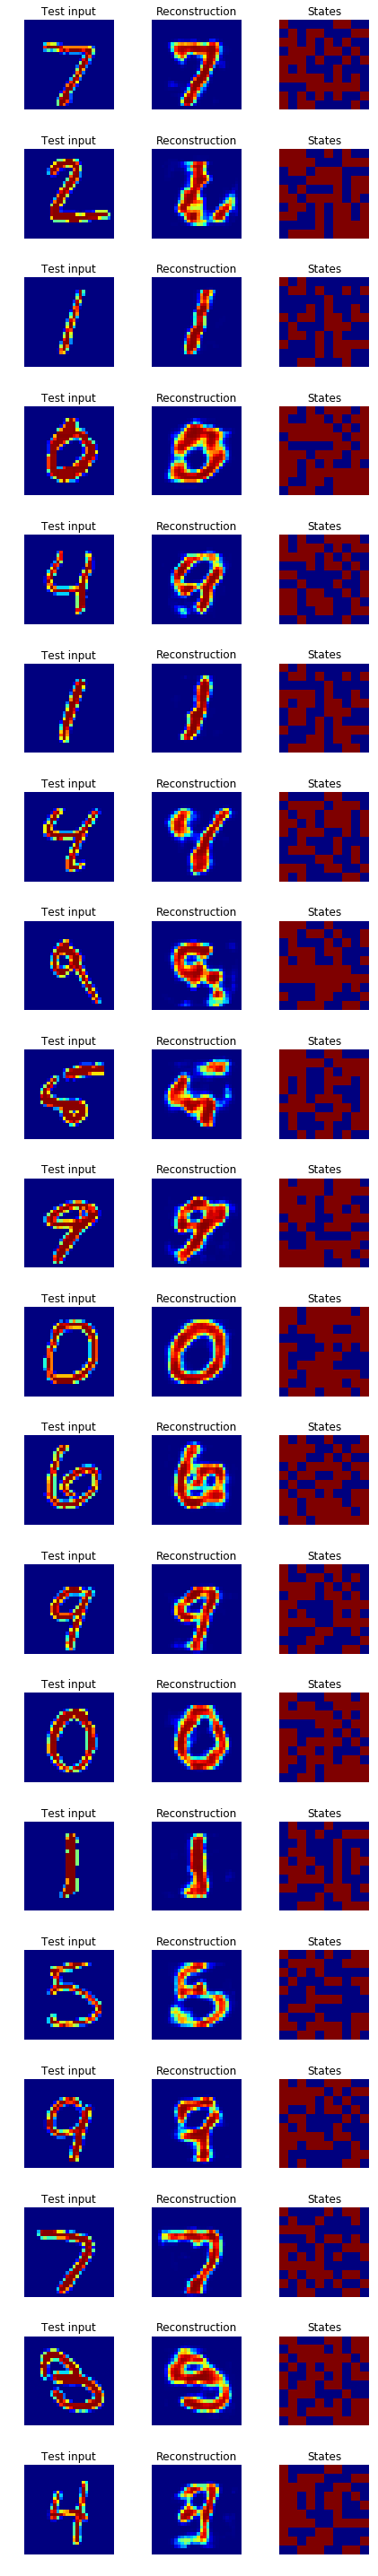

In [28]:
# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr2, h2downs, model.v_shape, model.h2_shape, numbers_count)

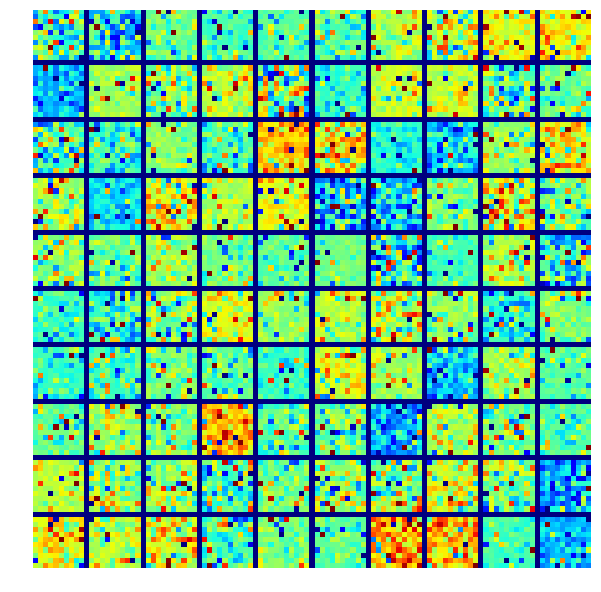

In [34]:
# vizualizacija težina
draw_weights(w2s, model.h1_shape, model.h2_count, model.h2_shape, interpolation="nearest")

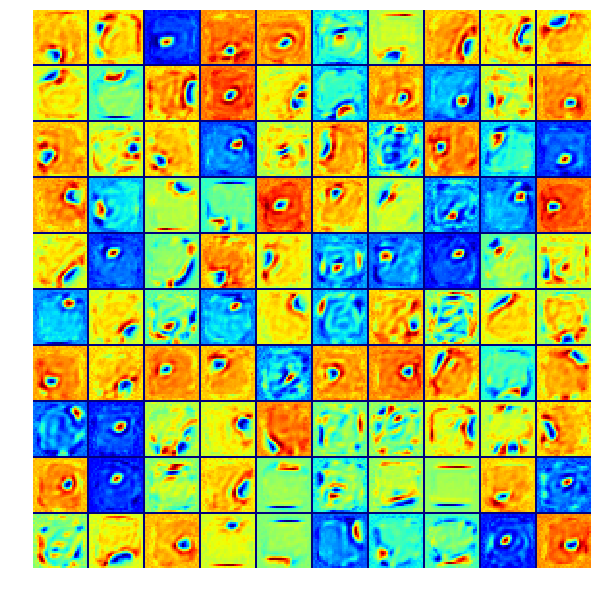

In [35]:
# vizualizacija težina
draw_weights(w1s, model.v_shape, model.h1_count, model.h1_shape, interpolation="nearest")

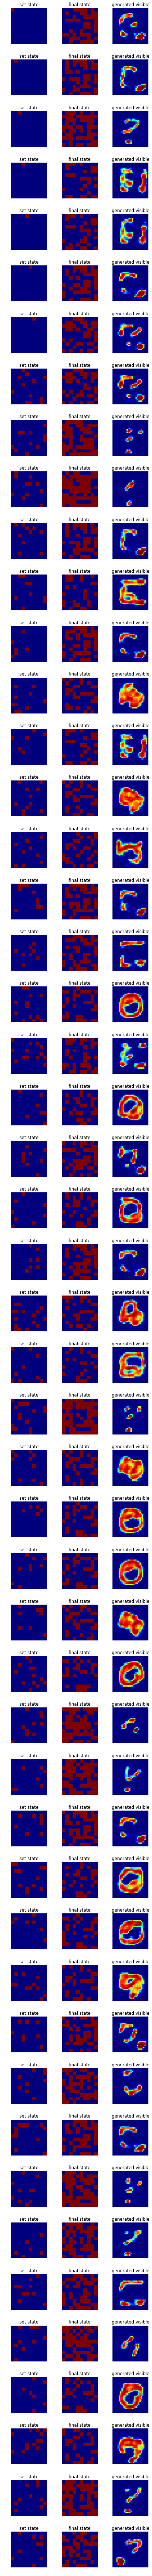

In [36]:
r_input = np.random.rand(100, model.h2_count)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_1 = model.session.run((model.v_out), feed_dict={model.h2up: r_input})

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = rbm.session.run((rbm.v1_prob, rbm.v1, rbm.h1), feed_dict={rbm.X1: out_1})

draw_generated(r_input, hout1, out_1_prob, rbm.v_shape, rbm.h1_shape, 50)

## Zadatak 3

In [37]:
class RBMTuned:
    def __init__(self, rbm, dbn, gibbs_sampling_steps, learning_rate, beta=0.01):
        self.v_count = dbn.v_count; self.v_shape = dbn.v_shape
        self.h1_count = dbn.h1_count; self.h1_shape = dbn.h1_shape
        self.h2_count = dbn.h2_count; self.h2_shape = dbn.h2_shape
        self.dbn = dbn; self.rbm = rbm
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            w1s, vb1s, hb1s = rbm.get_params()
            w2s, hb1as, hb2s = dbn.get_params()

            self.X3 = tf.placeholder("float", [None, self.v_count])
            self.r1_up = tf.Variable(w1s)
            self.w1_down = tf.Variable(tf.transpose(w1s))
            self.w2a = tf.Variable(w2s)
            self.hb1_up = tf.Variable(hb1s)
            self.hb1_down = tf.Variable(hb1as)
            self.vb1_down = tf.Variable(vb1s)
            self.hb2a = tf.Variable(hb2s)
            
            # wake pass
            self.h1_up_prob = tf.nn.sigmoid(tf.matmul(self.X3, self.r1_up) + self.hb1_up) 
            self.h1_up = sample_prob(self.h1_up_prob) # s^{(n)} u pripremi
            self.v1_up_down_prob = tf.nn.sigmoid(tf.matmul(self.h1_up, self.w1_down) + self.vb1_down)
            self.v1_up_down = sample_prob(self.v1_up_down_prob) # s^{(n-1)\mathit{novo}} u tekstu pripreme
            
            # top RBM Gibs passes
            self.h2_up_prob = tf.nn.sigmoid(tf.matmul(self.h1_up, self.w2a) + self.hb2a)
            self.h2_up = sample_prob(self.h2_up_prob)
            self.h2_down = self.h2_up # self.h4 = ...
            
            for step in range(gibbs_sampling_steps):
                self.h1_down_prob = tf.nn.sigmoid(tf.matmul(self.h2_down, self.w2a, transpose_b=True) + self.hb1_down) 
                self.h1_down = sample_prob(self.h1_down_prob)
                self.h2_down_prob = tf.nn.sigmoid(tf.matmul(self.h1_down, self.w2a) + self.hb2a) 
                self.h2_down = sample_prob(self.h2_down_prob)
            
            # sleep pass
            self.v1_down_prob = tf.nn.sigmoid(tf.matmul(self.h1_down, self.w1_down) + tf.transpose(self.vb1_down))
            self.v1_down = sample_prob(self.v1_down_prob) # s^{(n-1)} u pripremi
            self.h1_down_up_prob = tf.nn.sigmoid(tf.matmul(self.v1_down, self.r1_up) + tf.transpose(self.hb1_up))
            self.h1_down_up = sample_prob(self.h1_down_prob) # s^{(n)\mathit{novo}} u pripremi
            
            # generative weights update during wake pass
            update_w1_down = tf.assign_add(self.w1_down, 
                                           beta * tf.matmul(tf.transpose(self.h1_up), self.X3 - self.v1_up_down_prob) 
                                           / tf.to_float(tf.shape(self.X3)[0]))
            update_vb1_down = tf.assign_add(self.vb1_down, beta * tf.reduce_mean(self.X3 - self.v1_up_down_prob, 0))

            # top RBM update
            w2_positive_grad = tf.matmul(self.h1_up_prob, self.h2_up_prob, transpose_a=True)
            w2_negative_grad = tf.matmul(self.h1_down_prob, self.h2_down, transpose_a=True)
            dw3 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(self.h1_up)[0]) 
            update_w2 = tf.assign_add(self.w2a, beta * dw3)
            update_hb1_down = tf.assign_add(self.hb1_down, beta * tf.reduce_mean(self.h1_up - self.h1_down, 0))
            update_hb2 = tf.assign_add(self.hb2a, beta * tf.reduce_mean(self.h2_up - self.h2_down, 0))
            
            # recognition weights update during sleep pass
            update_r1_up = tf.assign_add(self.r1_up, 
                                         beta * tf.matmul(tf.transpose(self.v1_down_prob), 
                                                          self.h1_down - self.h1_down_up) / tf.to_float(tf.shape(self.X3)[0]))
            update_hb1_up = tf.assign_add(self.hb1_up, beta * tf.reduce_mean(self.h1_down - self.h1_down_up, 0))

            self.out3 = (update_w1_down, update_vb1_down, update_w2, update_hb1_down, update_hb2, update_r1_up, update_hb1_up)

            self.err3 = self.X3 - self.v1_down_prob
            self.err_sum3 = tf.reduce_mean(self.err3 * self.err3)

            self.initializer = tf.global_variables_initializer()

    def train(self, dataset, batch_size, epochs, print_step):
        n_samples = mnist.train.num_examples
        total_batch = int(n_samples / batch_size) * epochs
        self.session = tf.Session(graph=self.graph)
        self.session.run(self.initializer)

        for i in range(total_batch):
            batch, label = dataset.next_batch(batch_size)
            err, _ = self.session.run([self.err_sum3, self.out3], feed_dict={self.X3: batch})

            if i % print_step == 0:
                print("Batch:", i, "/", total_batch, "Error:", err)
            self.last_batch = batch
    
    def get_vr(self, samples):
        vr3s, h2_downs = self.session.run([self.v1_down_prob, self.h2_down], feed_dict={self.X3: teX[0:samples,:]})
        return vr3s, h2_downs

In [38]:
gibbs_sampling_steps = 2; learning_rate = 0.01
rbm_tuned = RBMTuned(rbm, dbn, gibbs_sampling_steps, learning_rate)
rbm_tuned.train(mnist.train, 100, 100, 100)

Batch: 0 / 55000 Error: 0.0372628
Batch: 100 / 55000 Error: 0.0352177
Batch: 200 / 55000 Error: 0.0354387
Batch: 300 / 55000 Error: 0.0355553
Batch: 400 / 55000 Error: 0.035187
Batch: 500 / 55000 Error: 0.0335634
Batch: 600 / 55000 Error: 0.035848
Batch: 700 / 55000 Error: 0.0339863
Batch: 800 / 55000 Error: 0.0350078
Batch: 900 / 55000 Error: 0.0317398
Batch: 1000 / 55000 Error: 0.0331337
Batch: 1100 / 55000 Error: 0.0335055
Batch: 1200 / 55000 Error: 0.0336373
Batch: 1300 / 55000 Error: 0.031408
Batch: 1400 / 55000 Error: 0.0349348
Batch: 1500 / 55000 Error: 0.0320411
Batch: 1600 / 55000 Error: 0.0298923
Batch: 1700 / 55000 Error: 0.0329716
Batch: 1800 / 55000 Error: 0.0331748
Batch: 1900 / 55000 Error: 0.0331352
Batch: 2000 / 55000 Error: 0.0325003
Batch: 2100 / 55000 Error: 0.0326083
Batch: 2200 / 55000 Error: 0.033175
Batch: 2300 / 55000 Error: 0.0310653
Batch: 2400 / 55000 Error: 0.0332285
Batch: 2500 / 55000 Error: 0.0329181
Batch: 2600 / 55000 Error: 0.0314887
Batch: 2700 / 550

Batch: 22000 / 55000 Error: 0.0326179
Batch: 22100 / 55000 Error: 0.0317423
Batch: 22200 / 55000 Error: 0.0298308
Batch: 22300 / 55000 Error: 0.0299643
Batch: 22400 / 55000 Error: 0.032543
Batch: 22500 / 55000 Error: 0.0309662
Batch: 22600 / 55000 Error: 0.0321989
Batch: 22700 / 55000 Error: 0.0324487
Batch: 22800 / 55000 Error: 0.0326095
Batch: 22900 / 55000 Error: 0.0323431
Batch: 23000 / 55000 Error: 0.0320453
Batch: 23100 / 55000 Error: 0.0299297
Batch: 23200 / 55000 Error: 0.030647
Batch: 23300 / 55000 Error: 0.0296036
Batch: 23400 / 55000 Error: 0.0323492
Batch: 23500 / 55000 Error: 0.0327732
Batch: 23600 / 55000 Error: 0.029355
Batch: 23700 / 55000 Error: 0.030304
Batch: 23800 / 55000 Error: 0.0304457
Batch: 23900 / 55000 Error: 0.0313259
Batch: 24000 / 55000 Error: 0.0291999
Batch: 24100 / 55000 Error: 0.0296599
Batch: 24200 / 55000 Error: 0.0292055
Batch: 24300 / 55000 Error: 0.033177
Batch: 24400 / 55000 Error: 0.0326746
Batch: 24500 / 55000 Error: 0.0320138
Batch: 24600 / 55

Batch: 43700 / 55000 Error: 0.0312091
Batch: 43800 / 55000 Error: 0.0324344
Batch: 43900 / 55000 Error: 0.0309906
Batch: 44000 / 55000 Error: 0.034031
Batch: 44100 / 55000 Error: 0.030657
Batch: 44200 / 55000 Error: 0.0303667
Batch: 44300 / 55000 Error: 0.0295766
Batch: 44400 / 55000 Error: 0.0313461
Batch: 44500 / 55000 Error: 0.0292752
Batch: 44600 / 55000 Error: 0.0325834
Batch: 44700 / 55000 Error: 0.0314115
Batch: 44800 / 55000 Error: 0.032396
Batch: 44900 / 55000 Error: 0.0314828
Batch: 45000 / 55000 Error: 0.0301492
Batch: 45100 / 55000 Error: 0.0320342
Batch: 45200 / 55000 Error: 0.0288206
Batch: 45300 / 55000 Error: 0.0308205
Batch: 45400 / 55000 Error: 0.0331296
Batch: 45500 / 55000 Error: 0.0305019
Batch: 45600 / 55000 Error: 0.0314962
Batch: 45700 / 55000 Error: 0.0325425
Batch: 45800 / 55000 Error: 0.0309617
Batch: 45900 / 55000 Error: 0.0296874
Batch: 46000 / 55000 Error: 0.0320912
Batch: 46100 / 55000 Error: 0.0317929
Batch: 46200 / 55000 Error: 0.028831
Batch: 46300 / 5

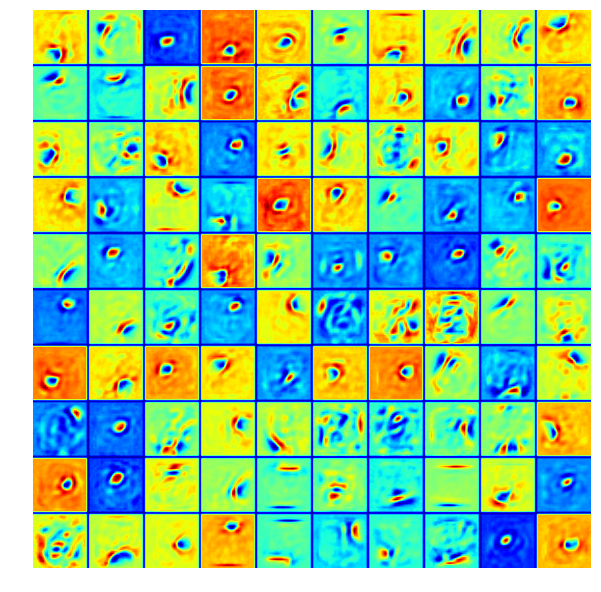

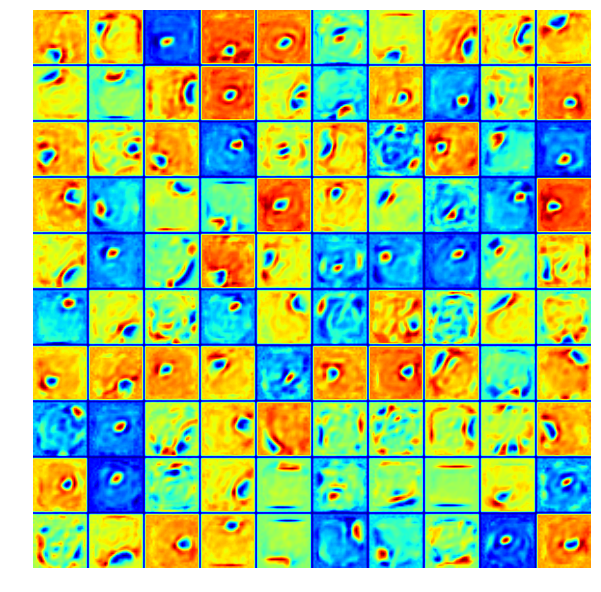

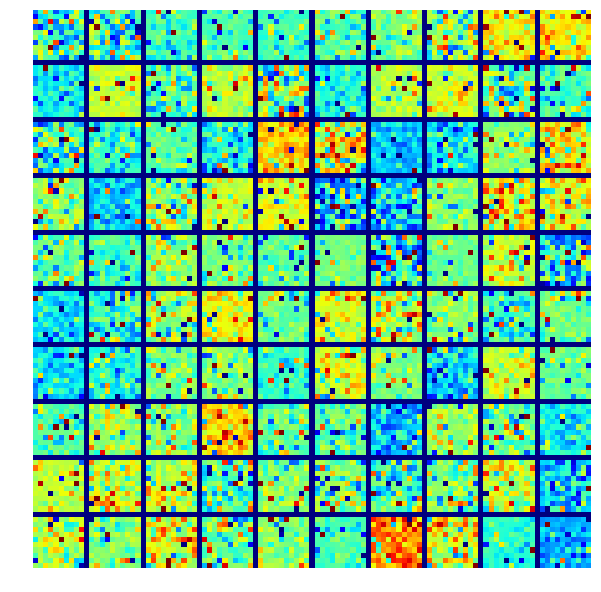

In [39]:
w2ss, r1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = rbm_tuned.session.run(
        [rbm_tuned.w2a, rbm_tuned.r1_up, rbm_tuned.w1_down, rbm_tuned.hb2a, 
         rbm_tuned.hb1_up, rbm_tuned.hb1_down, rbm_tuned.vb1_down], 
    feed_dict={rbm_tuned.X3: rbm_tuned.last_batch})
vr3, h2_downs, h2_down_probs = rbm_tuned.session.run([rbm_tuned.v1_down_prob, rbm_tuned.h2_down, rbm_tuned.h2_down_prob], 
                                                     feed_dict={rbm_tuned.X3: teX[0:20,:]})

# vizualizacija težina
draw_weights(r1_ups, rbm_tuned.v_shape, rbm_tuned.h1_count, rbm_tuned.h1_shape)
draw_weights(w1_downs.T, rbm_tuned.v_shape, rbm_tuned.h1_count, rbm_tuned.h1_shape)
draw_weights(w2ss, rbm_tuned.h1_shape, rbm_tuned.h2_count, rbm_tuned.h2_shape, interpolation="nearest")

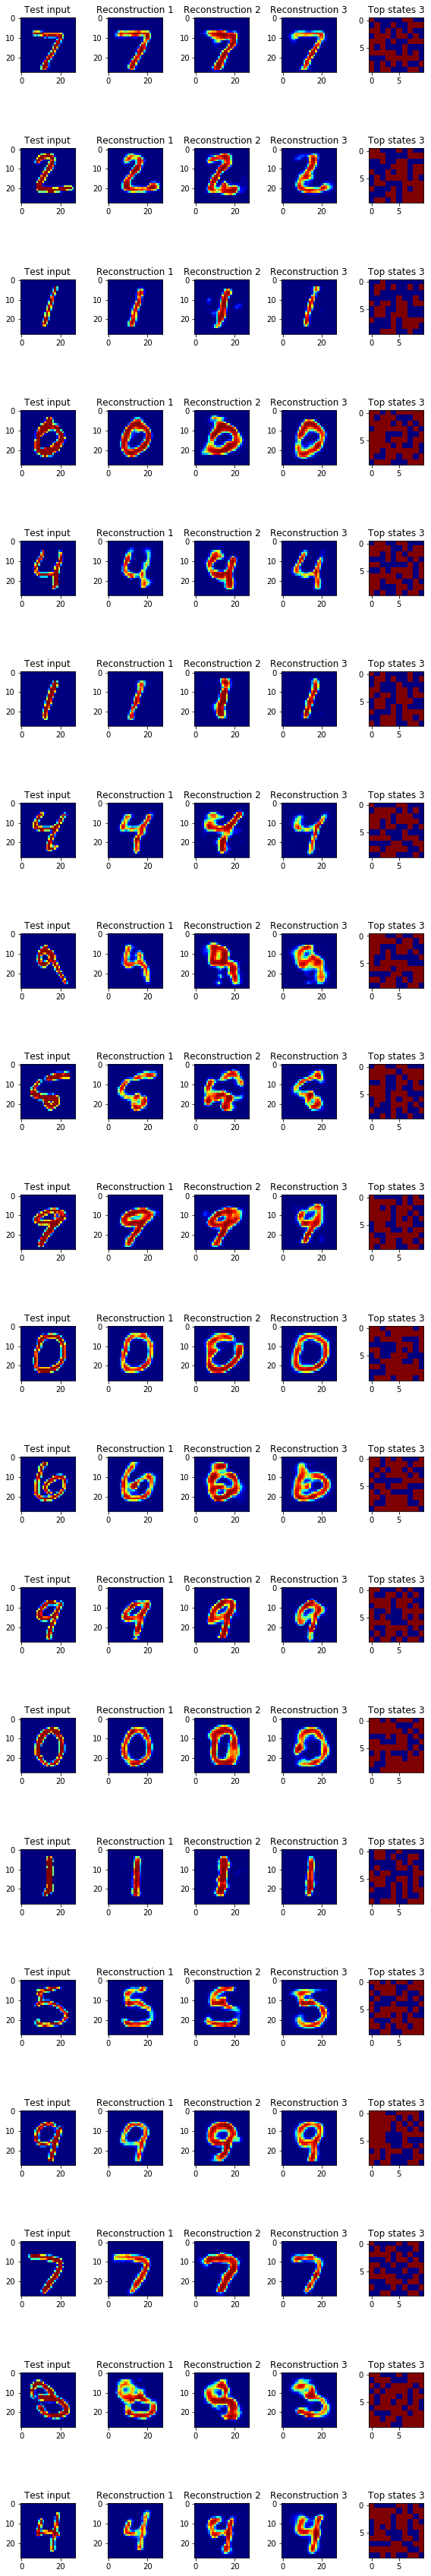

In [41]:
vr = rbm_tuned.rbm.get_vr(50)
vr2 = rbm_tuned.dbn.get_vr(50)
vr3, h2_downs = rbm_tuned.get_vr(50)
v_shape = rbm_tuned.v_shape
h2_count = rbm_tuned.h2_count
h2_shape = rbm_tuned.h2_shape

Npics = 5
plt.figure(figsize=(8, 12*4))
for i in range(20):

    plt.subplot(20, Npics, Npics*i + 1)
    plt.imshow(teX[i].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Test input")
    plt.subplot(20, Npics, Npics*i + 2)
    plt.imshow(vr[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 1")
    plt.subplot(20, Npics, Npics*i + 3)
    plt.imshow(vr2[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 2")
    plt.subplot(20, Npics, Npics*i + 4)
    plt.imshow(vr3[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 3")
    plt.subplot(20, Npics, Npics*i + 5)
    plt.imshow(h2_downs[i][0:h2_count].reshape(h2_shape), vmin=0, vmax=1, interpolation="nearest")
    plt.title("Top states 3")
plt.tight_layout()

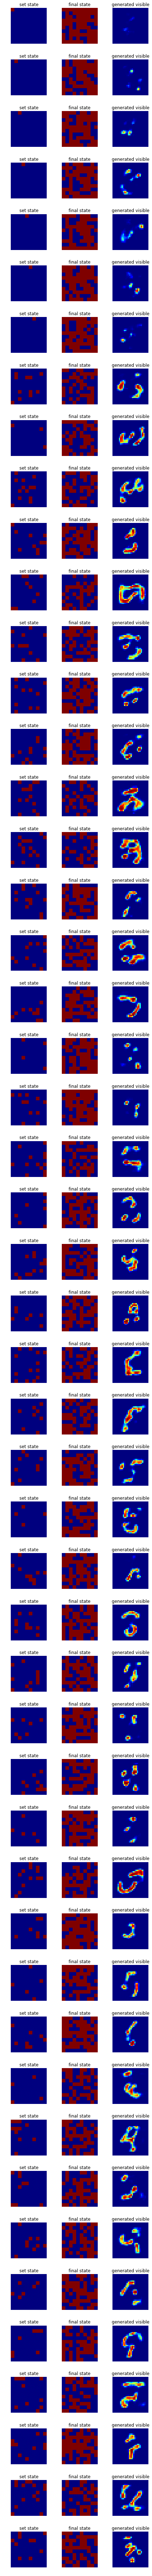

In [42]:
r_input = np.random.rand(100, rbm_tuned.h2_count)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_3 = rbm_tuned.session.run((rbm_tuned.v1_down), feed_dict={rbm_tuned.h2_up: r_input})

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = rbm.session.run((rbm.v1_prob, rbm.v1, rbm.h1), feed_dict={rbm.X1: out_3})

draw_generated(r_input, hout1, out_1_prob, rbm.v_shape, rbm.h1_shape, 50)

## Zadatak 4

#### Helper functions

In [46]:
def get_canvas(Z, ind, nx, ny, in_shape, batch_size, sess):
    """Crtanje rekonstrukcija na odgovarajućim pozicijama u 2D prostoru skrivenih varijabli
    Z -- skriveni vektori raspoređeni u gridu oko ishodišta
    ind -- indeksi za rezanje Z-a na batch_size blokove za slanje u graf -zbog problema sa random generatorom
    nx -- raspon grida po x osi - skrivena varijabla z0
    ny -- raspon grida po y osi - skrivena varijabla z1
    in_shape -- dimenzije jedne rekonstrukcije i.e. ulazne sličice
    batch_size -- veličina minibatcha na koji je graf naviknut
    sess -- session grafa mreže
    """
    # get reconstructions for visualiations
    X = np.empty((0,in_shape[0]*in_shape[1])) # empty array for concatenation 
    # split hidden vectors into minibatches of batch_size due to TF random generator limitation
    for batch in np.array_split(Z,ind):
        # fill up last batch to full batch_size if neccessary
        # this addition will not be visualized, but is here to avoid TF error
        if batch.shape[0] < batch_size:
            batch = np.concatenate((batch, np.zeros((batch_size-batch.shape[0], batch.shape[1]))), 0)
        # get batch_size reconstructions and add them to array of previous reconstructions
        X = np.vstack((X, sess.run(x_reconstr_mean_out, feed_dict={z: batch})))
    # make canvas with reconstruction tiles arranged by the hidden state coordinates of each reconstruction
    # this is achieved for all reconstructions by clever use of reshape, swapaxes and axis inversion
    return (X[0:nx*ny,:].reshape((nx*ny,in_shape[0],in_shape[1])).swapaxes(0,1)
            .reshape((in_shape[0],ny,nx*in_shape[1])).swapaxes(0,1)[::-1,:,:]
            .reshape((ny*in_shape[0],nx*in_shape[1])))

def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state),
                   vmin=-4, vmax=4, interpolation="nearest")
        plt.colorbar()
        plt.title("States")
    plt.tight_layout()
    
def plot_latent(inmat, labels):
    """Crtanje pozicija uzoraka u 2D latentnom prostoru
    inmat -- matrica latentnih stanja
    labels -- labela klas
    """
    plt.figure(figsize=(8, 6)) 
    plt.axis([-4, 4, -4, 4])
    plt.gca().set_autoscale_on(False)

    plt.scatter(inmat[:, 0], inmat[:, 1], c=np.argmax(labels, 1))
    plt.colorbar()
    plt.xlabel('z0')
    plt.ylabel('z1')

def save_latent_plot(name):
    """Spremanje trenutnog figure-a
    name -- ime datoteke
    """
    plt.savefig(name)
    
def weight_variable(shape, name):
    """Kreiranje težina"""
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    return tf.get_variable(name, shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """Kreiranje pomaka"""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def variable_summaries(var, name):
    """Prikupljanje podataka za Tensorboard"""
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram(name, var)

def vae_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softplus):
    """Kreiranje jednog skrivenog sloja"""
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        weights = weight_variable([input_dim, output_dim], layer_name + '/weights')
        variable_summaries(weights,'weights')
        tf.summary.tensor_summary('weightsT', weights)
        biases = bias_variable([output_dim])
        variable_summaries(biases, 'biases')
        preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
    return activations

In [47]:
n_samples = mnist.train.num_examples
learning_rate = 0.01
batch_size = 100

n_hidden_recog_1 = 200 # 1 sloj enkodera
n_hidden_recog_2 = 200 # 2 sloj enkodera
n_hidden_gener_1 = 200 # 1 sloj dekodera
n_hidden_gener_2 = 200 # 2 sloj dekodera
n_z = 20 # broj skrivenih varijabli
n_input = 784 # MNIST data input (img shape: 28*28)
in_shape = (28,28)

tf.reset_default_graph()
    
sess = tf.InteractiveSession()
        
# definicije ulaznog tenzora
# Add here
x = tf.placeholder("float", [None, n_input]) 

# definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
# Add here
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
# definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    # Add here
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity)
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    tf.summary.histogram('activations', z)

# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
# Add here
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
# Add here
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)

x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)

# definirajte dvije komponente funkcije cijene
with tf.name_scope('cost'):
    # Add here
    cost1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_reconstr_mean, labels=x)
    tf.summary.histogram('cross_entropy', cost1)
    # Add here
    cost2 = -0.5 * (1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq))
    tf.summary.histogram('D_KL', cost2)
    cost = tf.reduce_mean(tf.reduce_sum(cost1,1) + tf.reduce_sum(cost2,1))   # average over batch
    tf.summary.histogram('cost', cost)
                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Prikupljanje podataka za Tensorboard
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 20
train_writer = tf.summary.FileWriter('train', sess.graph)

sess.run(init)

total_batch = int(n_samples / batch_size)
step = 0
for epoch in range(n_epochs):
    avg_cost = 0.
        
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        # Compute average loss
        avg_cost += cos / n_samples * batch_size
        
    # Display logs per epoch step
    if epoch % 2 == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost =", "{:.9f}".format(avg_cost)) 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs}, 
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
        
        saver.save(sess, os.path.join('train', "model.ckpt"), epoch)

train_writer.close()

Epoch: 0001 cost = 170.970475603
Epoch: 0003 cost = 127.758567644
Epoch: 0005 cost = 124.435989685
Epoch: 0007 cost = 122.780431685
Epoch: 0009 cost = 121.391331870
Epoch: 0011 cost = 120.483789645
Epoch: 0013 cost = 119.622364238
Epoch: 0015 cost = 118.950301666
Epoch: 0017 cost = 118.468663344
Epoch: 0019 cost = 118.074975017


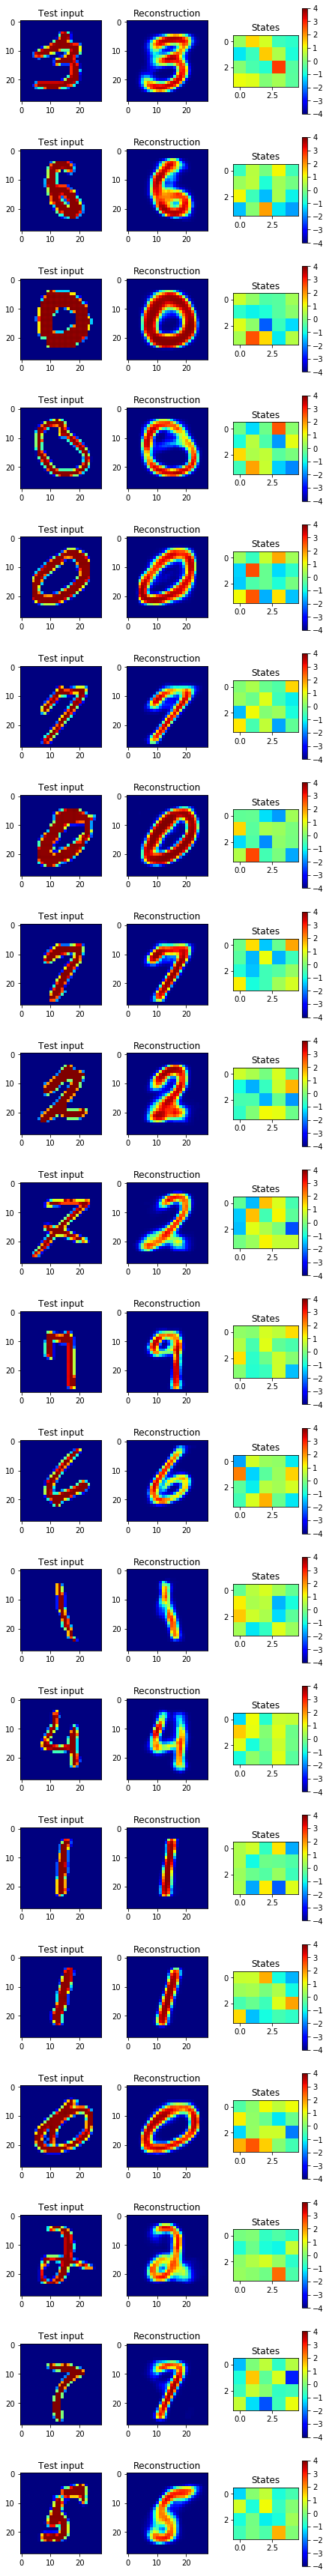

In [48]:
# 1. vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})

draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (4,5)) # prilagodite dimenzije prema potrebi

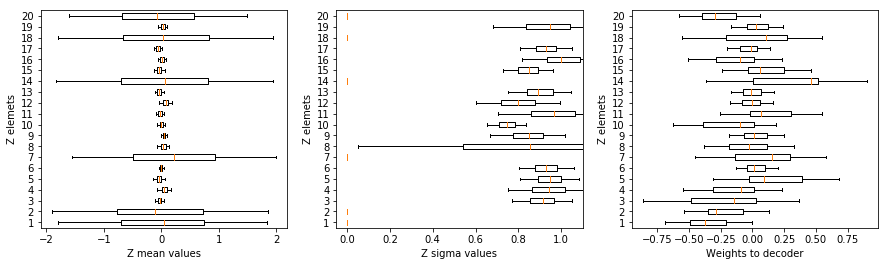

In [18]:
# 2. Vizualizirajte distribucije srednjih vrijednosti i standardnih devijacija skrivenih varijabli z za primjereni broj ulaznih uzoraka
# Pomoćna funkcija za crtanje boxplot grafova
def boxplot_vis(pos, input_data, label_x, label_y):
    ax = fig.add_subplot(130+pos)
    plt.boxplot(input_data, 0, '', 0, 0.75)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    return ax

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu, z_sigma = sess.run((z_mean, z_log_sigma_sq), feed_dict={x: x_sample})
   
fig = plt.figure(figsize=(15,4))
# Vizualizacija statistike za z_mean
boxplot_vis(1,z_mu, 'Z mean values', 'Z elemets')

# Vizualizacija statistike za z_sigma
ax = boxplot_vis(2, np.square(np.exp(z_sigma)), 'Z sigma values', 'Z elemets')
ax.set_xlim([-0.05,1.1])

# Vizualizacija statistike za težine ulaza u dekoder
test = tf.get_default_graph().get_tensor_by_name("layer_d1/weights:0")
weights_d1 = test.eval(session=sess)
boxplot_vis(3, weights_d1.T, 'Weights to decoder', 'Z elemets')

In [5]:
# 3. Z = 2
n_samples = mnist.train.num_examples
learning_rate = 0.001
batch_size = 100

n_hidden_recog_1 = 200 # 1 sloj enkodera
n_hidden_recog_2 = 200 # 2 sloj enkodera
n_hidden_gener_1 = 200 # 1 sloj dekodera
n_hidden_gener_2 = 200 # 2 sloj dekodera
n_z = 2 # broj skrivenih varijabli
n_input = 784 # MNIST data input (img shape: 28*28)
in_shape = (28,28)

tf.reset_default_graph()
    
sess = tf.InteractiveSession()
        
# definicije ulaznog tenzora
# Add here
x = tf.placeholder("float", [None, n_input]) 

# definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
# Add here
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
# definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    # Add here
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity)
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    tf.summary.histogram('activations', z)

# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
# Add here
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
# Add here
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)

x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)

# definirajte dvije komponente funkcije cijene
with tf.name_scope('cost'):
    # Add here
    cost1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_reconstr_mean, labels=x)
    tf.summary.histogram('cross_entropy', cost1)
    # Add here
    cost2 = -0.5 * (1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq))
    tf.summary.histogram('D_KL', cost2)
    cost = tf.reduce_mean(tf.reduce_sum(cost1,1) + tf.reduce_sum(cost2,1))   # average over batch
    tf.summary.histogram('cost', cost)
                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Prikupljanje podataka za Tensorboard
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 50
train_writer = tf.summary.FileWriter('train', sess.graph)

sess.run(init)

total_batch = int(n_samples / batch_size)
step = 0
for epoch in range(n_epochs):
    avg_cost = 0.
        
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        # Compute average loss
        avg_cost += cos / n_samples * batch_size
        
    # Display logs per epoch step
    if epoch % 2 == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost =", "{:.9f}".format(avg_cost)) 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs}, 
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
        
        saver.save(sess, os.path.join('train', "model.ckpt"), epoch)

train_writer.close()

Epoch: 0001 cost = 189.060293551
Epoch: 0003 cost = 159.654533497
Epoch: 0005 cost = 154.572176625
Epoch: 0007 cost = 151.897285822
Epoch: 0009 cost = 151.176994962
Epoch: 0011 cost = 160.763485329
Epoch: 0013 cost = 150.535362660
Epoch: 0015 cost = 148.949922541
Epoch: 0017 cost = 148.568264549
Epoch: 0019 cost = 148.202978987
Epoch: 0021 cost = 147.427184254
Epoch: 0023 cost = 146.950340521
Epoch: 0025 cost = 146.610879933
Epoch: 0027 cost = 146.420354878
Epoch: 0029 cost = 152.833946284
Epoch: 0031 cost = 149.895267500
Epoch: 0033 cost = 148.520531616
Epoch: 0035 cost = 147.653865884
Epoch: 0037 cost = 149.852997131
Epoch: 0039 cost = 148.208460333
Epoch: 0041 cost = 147.633873735
Epoch: 0043 cost = 156.384651683
Epoch: 0045 cost = 152.874049045
Epoch: 0047 cost = 150.559803189
Epoch: 0049 cost = 150.254111078


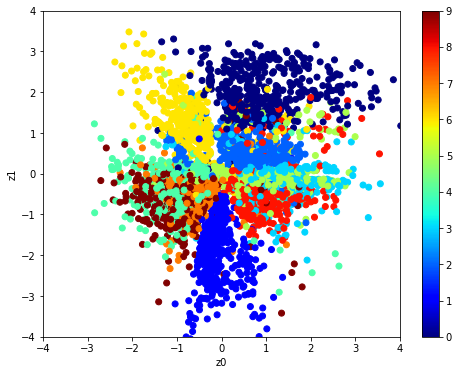

In [7]:
# 4. Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)  
z_mu, z_sigma = sess.run((z_mean, z_log_sigma_sq), feed_dict={x: x_sample})
plot_latent(z_mu, y_sample)

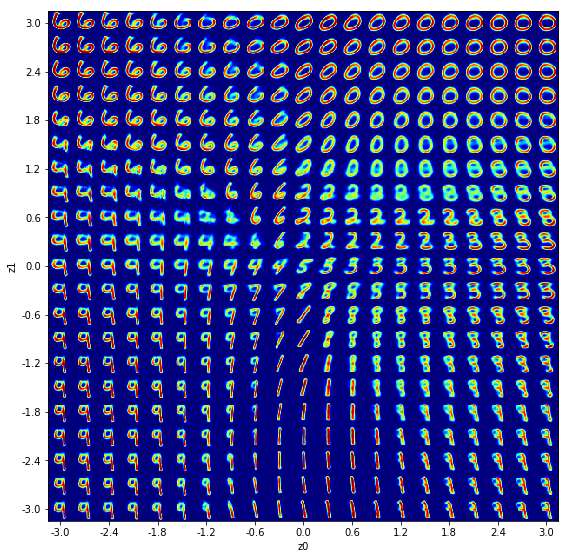

In [8]:
# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način
nx = ny = 21
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
# Trikovito popunjavanje rezultata za grid zbog fiksirane veličine z batcha u grafu
# Valjda će se to riješiti u nekoj budućoj verziji TF
Xi, Yi = np.meshgrid(x_values, y_values)
Z = np.column_stack((Xi.flatten(), Yi.flatten()))
X = np.empty((0,28*28))
ind = list(range(batch_size, nx*ny, batch_size))
for i in np.array_split(Z,ind):
    if i.shape[0] < batch_size:
        i = np.concatenate((i, np.zeros((batch_size-i.shape[0], i.shape[1]))), 0)
    X = np.vstack((X, sess.run(x_reconstr_mean_out, feed_dict={z: i})))
    
for i, yi in enumerate(y_values):
    for j, xi in enumerate(x_values):
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = X[i*nx+j].reshape(28, 28)

plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper")
plt.xticks( np.linspace(14,588-14,11), np.round(np.linspace(-3,3,11), 2) )
plt.yticks( np.linspace(14,588-14,11), np.round(np.linspace(3,-3,11), 2) )
plt.xlabel('z0')
plt.ylabel('z1')
plt.tight_layout()

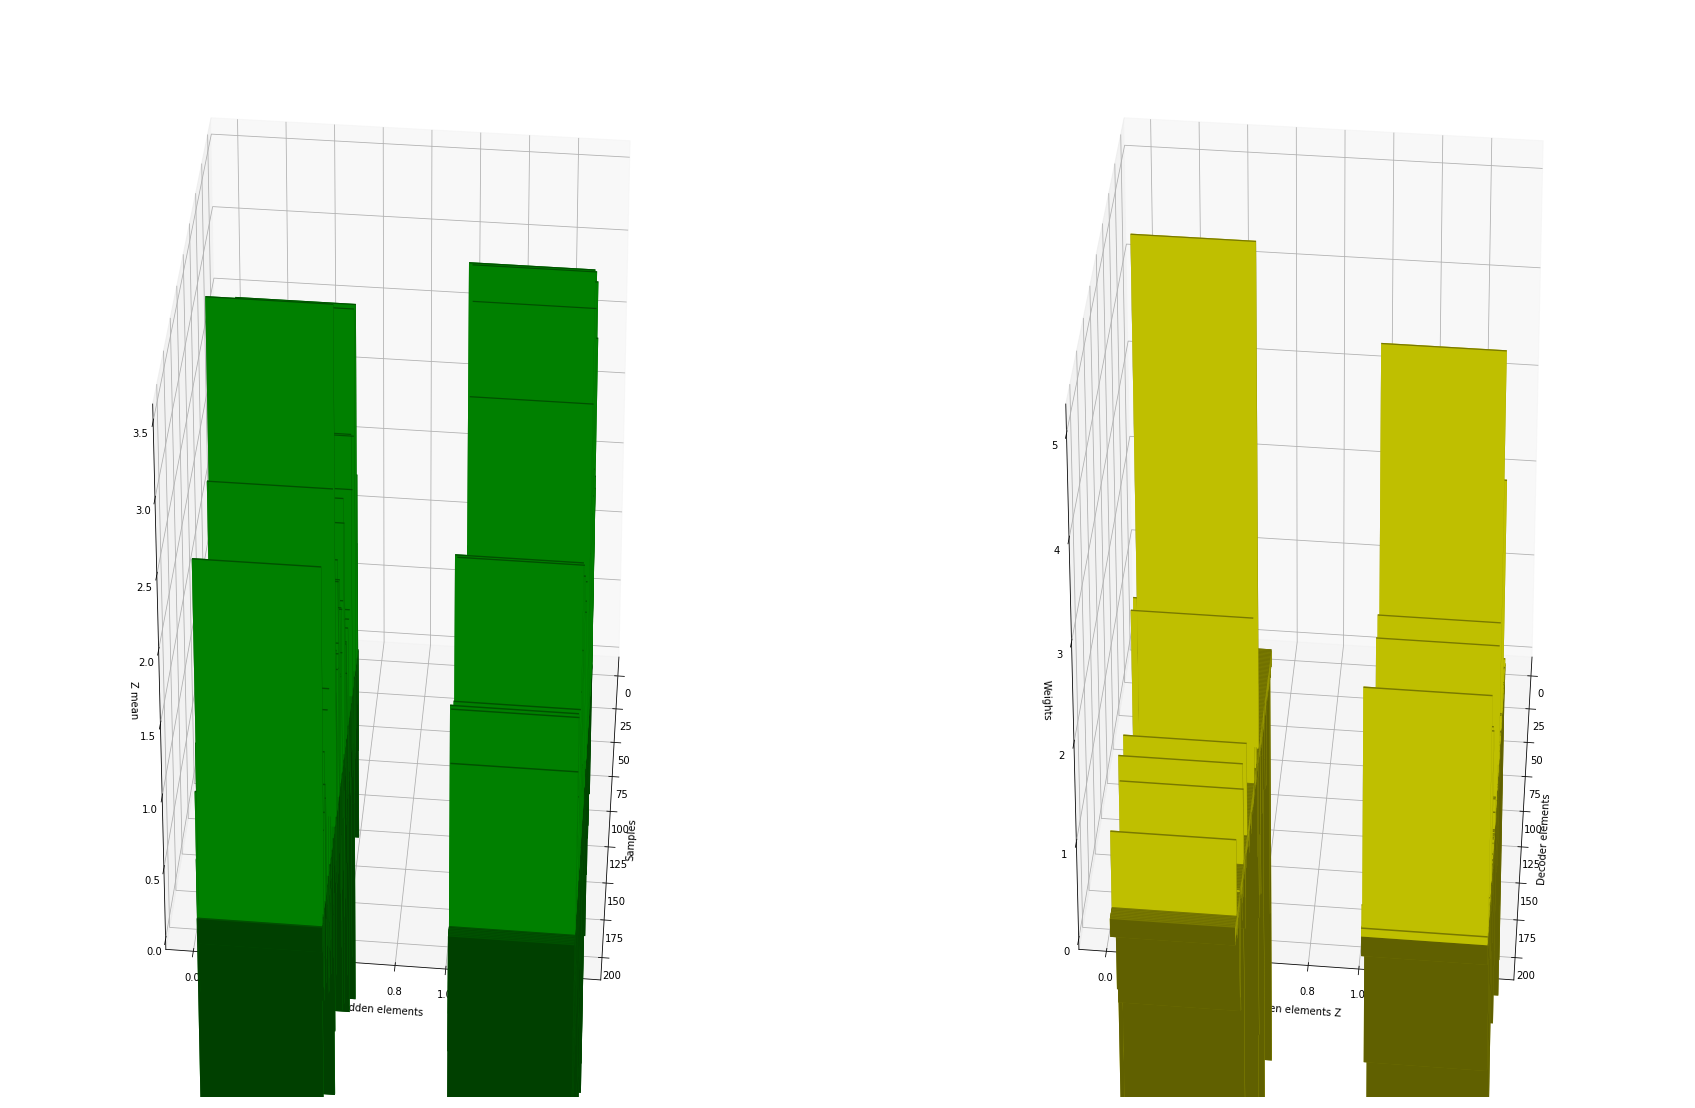

In [10]:
# Vizualizacija ugašenih elemenata skrivenog sloja - 2. način
# Funkcija za crtanje 3D bar grafa
def bargraph_vis(pos, input_data, dims, color, labels):
    ax = fig.add_subplot(120+pos, projection='3d')
    xpos, ypos = np.meshgrid(range(dims[0]), range(dims[1]))
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)
    
    dx = np.ones_like(zpos) 
    dy = np.ones_like(zpos) * 0.5
    dz = input_data.flatten()[0:dx.shape[0]]
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color)
    ax.view_init(elev=30., azim=5)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
                             
fig = plt.figure(figsize=(30,20))
test = tf.get_default_graph().get_tensor_by_name("layer_d1/weights:0")
weights_d1 = test.eval(session=sess)
# 3D bar graf za z_mean
labels = ('Samples', 'Hidden elements', 'Z mean')
bargraph_vis(1, z_mu, [200, z_mu.shape[1]], 'g', labels)

# 3D bar graf za težine iz z_mena u dekoder
labels = ('Decoder elements', 'Hidden elements Z', 'Weights')
bargraph_vis(2, weights_d1.T, weights_d1.T.shape, 'y', labels)